# Hello, Data!
**My Python-MONAN-data first attempt.**

---
**Load libraries**

Triangulations => Matplotlib's tool for handling unstructured meshes <br>
Matplotlib => Standard plotting interface <br>
xarray => is a high-level interface for multi-dimensional data


In [1]:
from matplotlib.tri import Triangulation
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
cartopy.config['data_dir'] = '/home2/eduardo.eras/workspace/python/cartopy_data'


---
**Load data**

In [2]:
path = "/p/projetos/monan_atm/eduardo.eras/MONAN/scripts_CD-CT/dataout/2025102500/Model/MONAN_DIAG_G_MOD_GFS_2025102500_2025102600.00.00.x40962L55.nc"

data = xr.open_dataset(path, engine = "netcdf4")
monan_lons = data['lonCell']
monan_lats = data['latCell']

---
### Building the triangulation (unstructured MONAN grid)

MONAN provides horizontal grid coordinates (`lonCell`, `latCell`) in **radians**.
However, Cartopy map projections expect **longitude and latitude in degrees**.

The steps below:
1. Convert MONAN cell-center coordinates from radians to degrees
2. Build a triangulation in degree space
3. Use this triangulation for geographic plotting

This ensures that the unstructured grid is correctly positioned on the Earth.

In [3]:
# Convert coordinates from radians to degrees
monan_lons_deg = np.degrees(monan_lons.values)
monan_lats_deg = np.degrees(monan_lats.values)

# Build triangulation with degree coordinates
tri = Triangulation(monan_lons_deg, monan_lats_deg)

---
### Creating and rendering a georeferenced map of a MONAN diagnostic field

This block creates a georeferenced map using Cartopy and Matplotlib and
renders a MONAN diagnostic variable on its native unstructured grid.

The steps performed are:

1. **Create a Cartopy map axes**:
   A Matplotlib figure and axes are created using the `PlateCarree`
   projection, which assumes longitude and latitude expressed in degrees.
   This projection is appropriate because the MONAN cell-center coordinates
   have been converted from radians to degrees.

2. **Define the geographic extent**:
   The map domain is restricted to the MONAN model domain by computing the
   minimum and maximum longitude and latitude values of the cell centers.
   This ensures the plot is focused on the simulated region.

3. **Add geographic reference features**:
   Coastlines and international borders are added to provide spatial context.
   Gridlines with latitude and longitude labels are drawn to aid orientation
   and interpretation.

4. **Plot the diagnostic field on the unstructured grid**:
   The selected MONAN variable is plotted using a triangular mesh
   (`Triangulation`) that represents the native unstructured grid.
   Each triangle corresponds to a model cell and is colored according to the
   cell-centered value at the selected time.

5. **Attach a colorbar**:
   A colorbar is added to relate the color shading to physical values of the
   plotted variable.

This approach visualizes the model output in its native grid without
interpolation or remapping, making it suitable for diagnostic and exploratory
analysis.

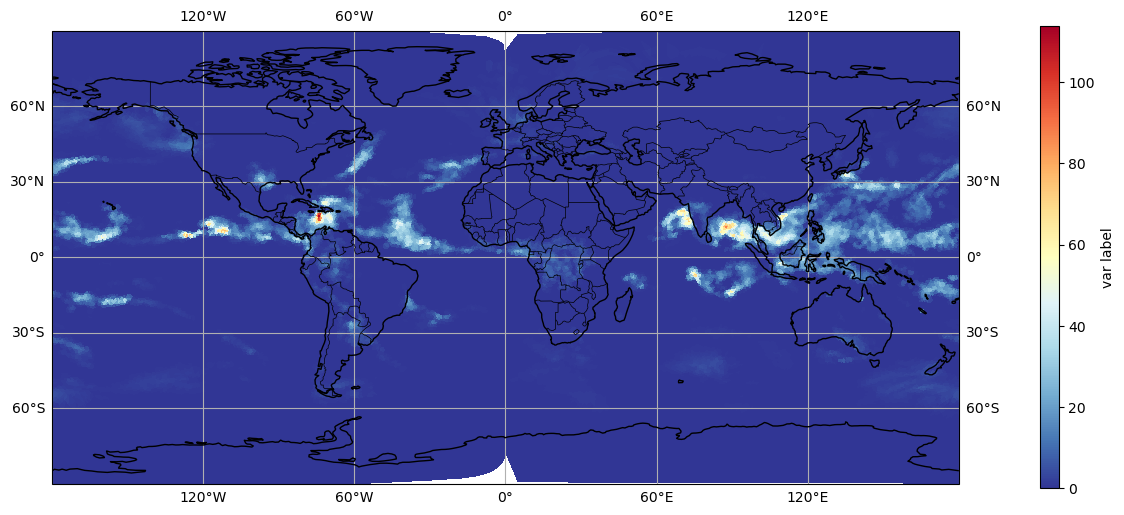

In [7]:
#Create a Cartopy map axes
fig, ax = plt.subplots(
    figsize=(15, 12),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

#Define the geographic extent
ax.set_extent(
    [monan_lons_deg.min(),
     monan_lons_deg.max(),
     monan_lats_deg.min(),
     monan_lats_deg.max()],
     crs=ccrs.PlateCarree()
)

#Add geographic reference features
ax.add_feature(
    cfeature.COASTLINE,
    linewidth=1.0,
    zorder=10
)

ax.add_feature(
    cfeature.BORDERS,
    linewidth=0.5,
    zorder=10
)

ax.gridlines(draw_labels=True)

#Plot the diagnostic field on the unstructured grid
tpc = ax.tripcolor(
    tri,
    data["rainc"].isel(Time=0),
    cmap="RdYlBu_r",
    shading="flat",
    transform=ccrs.PlateCarree()
)

#Attach a colorbar
plt.colorbar(
    tpc,
    label="var label",
    shrink=0.5,
    aspect=25,
    pad=0.07
)

---
### Diagnose section

Checks Natural Earth coastline data availability and its directory path integrity.

In [ ]:
import cartopy.io.shapereader as shapereader
import os

# Check data coordinate ranges
print("Data coordinate ranges:")
print(f"Longitude: min={monan_lons.min().values:.2f}, max={monan_lons.max().values:.2f}")
print(f"Latitude: min={monan_lats.min().values:.2f}, max={monan_lats.max().values:.2f}")

# Check what features are available
print("\nAvailable features:")
print(f"COASTLINE: {cfeature.COASTLINE}")
print(f"BORDERS: {cfeature.BORDERS}")

# Try to load the actual shapefiles
print("\nTrying to load Natural Earth data:")
try:
    coast_path = shapereader.natural_earth('110m', 'physical', 'coastline')
    print(f"110m coastline: {coast_path}")
    print(f"  File exists: {os.path.exists(coast_path)}")
except Exception as e:
    print(f"  110m Error: {e}")

try:
    boundary_path = shapereader.natural_earth('110m', 'cultural', 'admin_0_boundary_lines_land')
    print(f"110m boundaries: {boundary_path}")
    print(f"  File exists: {os.path.exists(boundary_path)}")
except Exception as e:
    print(f"  110m Error: {e}")
